In [19]:
import os
import random
import warnings
from prophet.plot import add_changepoints_to_plot
import numpy as np
import pandas as pd
from prophet import Prophet

warnings.filterwarnings(action='ignore')

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [3]:
info = pd.read_csv('./building_info.csv')
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

## 가장 결과가 좋았던 외생변수 4종을 포함한 코드에 prameter 최적화를 수행한다

14:04:50 - cmdstanpy - INFO - Chain [1] start processing
14:04:51 - cmdstanpy - INFO - Chain [1] done processing


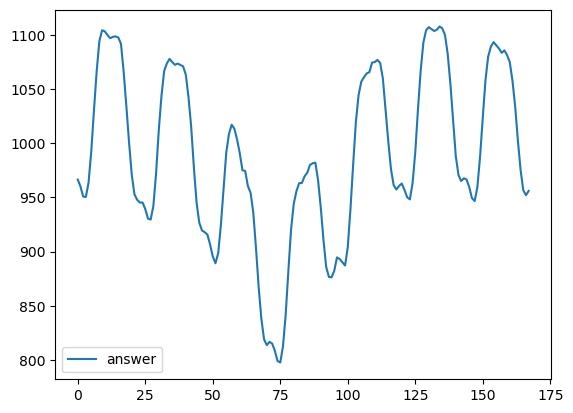

In [27]:
target_num = 55
test_submission= pd.DataFrame(columns=['num_date_time', 'answer'])
fillzero_train = train_df.fillna(0)
sample_train = fillzero_train.loc[fillzero_train["건물번호"]==target_num]
target = sample_train["num_date_time"].str.split("_").apply(lambda  x: x[1])
sample_train["num_date_time"] = pd.to_datetime(target, format = "%Y%m%d %H")
data = sample_train.rename(columns={'num_date_time': 'ds', "전력소비량(kWh)":'y'})[['ds','y','기온(C)','강수량(mm)','풍속(m/s)','습도(%)']].reset_index(drop=True)

m= Prophet(
             growth: Any = 'linear',
             changepoints: Any = None,
             n_changepoints: Any = 25,
             changepoint_range: Any = 0.8,
             yearly_seasonality: Any = 'auto',
             weekly_seasonality: Any = 'auto',
             daily_seasonality: Any = 'auto',
             holidays: Any = None,
             # seasonality_mode: Any = 'additive',
             seasonality_prior_scale: Any = 10.0,
             holidays_prior_scale: Any = 10.0,
             changepoint_prior_scale: Any = 0.05,
             mcmc_samples: Any = 0,
             interval_width: Any = 0.80,
             uncertainty_samples: Any = 1000,
             stan_backend: Any = None)
m.add_regressor('기온(C)')
m.add_regressor('강수량(mm)')
m.add_regressor('풍속(m/s)')
m.add_regressor('습도(%)')
m.fit(data)

future = m.make_future_dataframe(periods=168, freq='1H')
future['기온(C)'] = data['기온(C)']
future['강수량(mm)'] = data['강수량(mm)']
future['풍속(m/s)'] = data['풍속(m/s)']
future['습도(%)'] = data['습도(%)']

future.loc[future.shape[0]-168:,'기온(C)'] = test_df.loc[(target_num-1)*168:target_num*168-1,'기온(C)'].values
future.loc[future.shape[0]-168:,'강수량(mm)'] = test_df.loc[(target_num-1)*168:target_num*168-1,'강수량(mm)'].values
future.loc[future.shape[0]-168:,'풍속(m/s)'] = test_df.loc[(target_num-1)*168:target_num*168-1,'풍속(m/s)'].values
future.loc[future.shape[0]-168:,'습도(%)'] = test_df.loc[(target_num-1)*168:target_num*168-1,'습도(%)'].values

forecast = m.predict(future)

# Rest of the code



answer =forecast[-168:].loc[:,['ds','yhat']].rename(columns= {"ds": "num_date_time", "yhat":"answer"}).reset_index(drop=True)

answer["year"]=answer["num_date_time"].dt.year.astype(str)
answer["month"]=answer["num_date_time"].dt.month.astype(str).str.zfill(2)
answer["day"]=answer["num_date_time"].dt.day.astype(str).str.zfill(2)
answer["hour"]=answer["num_date_time"].dt.hour.astype(str).str.zfill(2)
answer["num_date_time"] = f"{target_num}_"+answer["year"] + answer["month"] + answer["day"] +' '+ answer["hour"]
test_submission = test_submission.append(answer)
test_submission.plot();

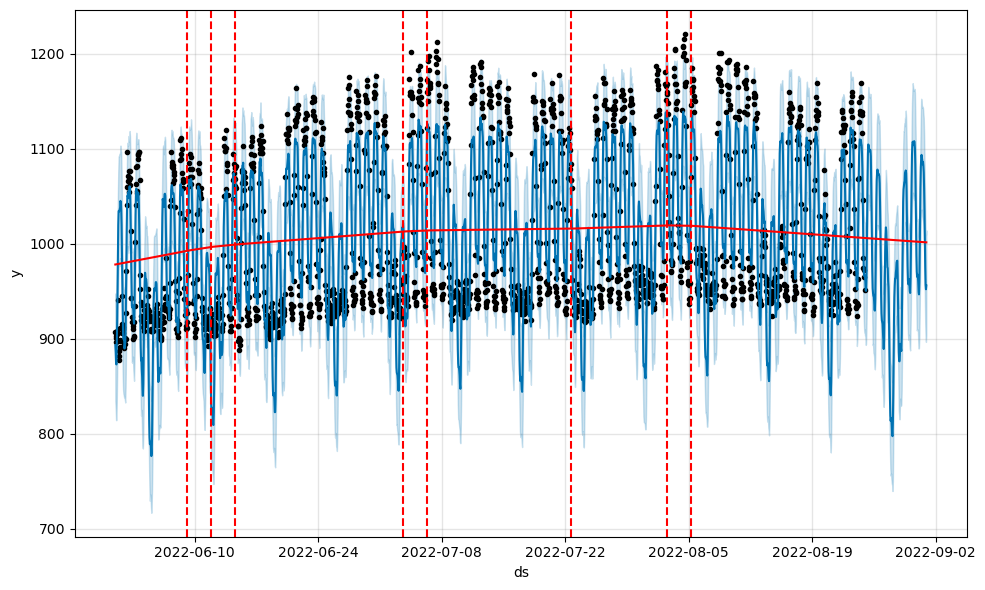

In [25]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [22]:
help(add_changepoints_to_plot)

Help on function add_changepoints_to_plot in module prophet.plot:

add_changepoints_to_plot(ax, m, fcst, threshold=0.01, cp_color='r', cp_linestyle='--', trend=True)
    Add markers for significant changepoints to prophet forecast plot.
    
    Example:
    fig = m.plot(forecast)
    add_changepoints_to_plot(fig.gca(), m, forecast)
    
    Parameters
    ----------
    ax: axis on which to overlay changepoint markers.
    m: Prophet model.
    fcst: Forecast output from m.predict.
    threshold: Threshold on trend change magnitude for significance.
    cp_color: Color of changepoint markers.
    cp_linestyle: Linestyle for changepoint markers.
    trend: If True, will also overlay the trend.
    
    Returns
    -------
    a list of matplotlib artists



In [29]:
test_submission= pd.DataFrame(columns=['num_date_time', 'answer'])
fillzero_train = train_df.fillna(0)
for i in range(1,101):
    # 한건물당 168개씩 예측한다
    sample_train = fillzero_train.loc[fillzero_train["건물번호"]==i]
    target = sample_train["num_date_time"].str.split("_").apply(lambda  x: x[1])
    sample_train["num_date_time"] = pd.to_datetime(target, format = "%Y%m%d %H")
    data = sample_train.rename(columns={'num_date_time': 'ds', "전력소비량(kWh)":'y'})[['ds','y','기온(C)','강수량(mm)','풍속(m/s)','습도(%)']].reset_index(drop=True)

    m= Prophet(seasonality_mode='multiplicative')
    m.add_regressor('기온(C)')
    m.add_regressor('강수량(mm)')
    m.add_regressor('풍속(m/s)')
    m.add_regressor('습도(%)')
    m.fit(data)

    future = m.make_future_dataframe(periods=168, freq='1H')
    future['기온(C)'] = data['기온(C)']
    future['강수량(mm)'] = data['강수량(mm)']
    future['풍속(m/s)'] = data['풍속(m/s)']
    future['습도(%)'] = data['습도(%)']

    future.loc[future.shape[0]-168:,'기온(C)'] = test_df.loc[(i-1)*168:i*168-1,'기온(C)'].values
    future.loc[future.shape[0]-168:,'강수량(mm)'] = test_df.loc[(i-1)*168:i*168-1,'강수량(mm)'].values
    future.loc[future.shape[0]-168:,'풍속(m/s)'] = test_df.loc[(i-1)*168:i*168-1,'풍속(m/s)'].values
    future.loc[future.shape[0]-168:,'습도(%)'] = test_df.loc[(i-1)*168:i*168-1,'습도(%)'].values

    forecast = m.predict(future)

    # Rest of the code



    answer =forecast[-168:].loc[:,['ds','yhat']].rename(columns= {"ds": "num_date_time", "yhat":"answer"}).reset_index(drop=True)

    answer["year"]=answer["num_date_time"].dt.year.astype(str)
    answer["month"]=answer["num_date_time"].dt.month.astype(str).str.zfill(2)
    answer["day"]=answer["num_date_time"].dt.day.astype(str).str.zfill(2)
    answer["hour"]=answer["num_date_time"].dt.hour.astype(str).str.zfill(2)
    answer["num_date_time"] = f"{i}_"+answer["year"] + answer["month"] + answer["day"] +' '+ answer["hour"]
    test_submission = test_submission.append(answer)
test_submission = test_submission[["num_date_time","answer"]]
test_submission.set_index("num_date_time",inplace= True)

14:05:33 - cmdstanpy - INFO - Chain [1] start processing
14:05:33 - cmdstanpy - INFO - Chain [1] done processing
14:05:34 - cmdstanpy - INFO - Chain [1] start processing
14:05:34 - cmdstanpy - INFO - Chain [1] done processing
14:05:34 - cmdstanpy - INFO - Chain [1] start processing
14:05:35 - cmdstanpy - INFO - Chain [1] done processing
14:05:35 - cmdstanpy - INFO - Chain [1] start processing
14:05:35 - cmdstanpy - INFO - Chain [1] done processing
14:05:35 - cmdstanpy - INFO - Chain [1] start processing
14:05:36 - cmdstanpy - INFO - Chain [1] done processing
14:05:36 - cmdstanpy - INFO - Chain [1] start processing
14:05:36 - cmdstanpy - INFO - Chain [1] done processing
14:05:36 - cmdstanpy - INFO - Chain [1] start processing
14:05:37 - cmdstanpy - INFO - Chain [1] done processing
14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:37 - cmdstanpy - INFO - Chain [1] done processing
14:05:38 - cmdstanpy - INFO - Chain [1] start processing
14:05:38 - cmdstanpy - INFO - Chain [1]

In [30]:
test_submission.to_csv("results/2023-08-11.csv")

## 11.4580 -> 11.6945로 정확도 낮아짐